In [1]:
import warnings
warnings.filterwarnings('ignore')

#General Data/Plotting
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from tqdm.auto import tqdm 
import random

# Language
import nltk 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
import re 
from collections import Counter
from string import punctuation
import textstat # pip install textstat

# Modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split 
from sklearn.metrics import precision_score, recall_score , f1_score, accuracy_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential 
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Dense , Embedding , Bidirectional , LSTM

lemma = WordNetLemmatizer()

In [2]:
df = pd.read_csv('../Datasets/Modified_Books_rating.csv')
df.head()

,Title,helpful,Rating,Title.1,Review,helpful_0,helpful_1,ratio_percent,review_len,IsHelpful,cleaned_reviews
0,Alaska Sourdough,36/37,5.0,Real Alaskan Sourdough,Ruth Allman has written an excellent book abou...,36,37,97,153,1,ruth allman written excellent book alaskan sou...
1,Alaska Sourdough,29/30,5.0,True Alaskan cooking,"I have been using this book since 1988, the ei...",29,30,96,63,1,i using book since eighth printing i honestly ...
2,Alaska Sourdough,25/28,5.0,Cheechako to Sourdough in 190 Pages,"My poor dogeared, stained copy of this book ca...",25,28,89,206,1,my poor dogeared stained copy book came way da...
3,Eyewitness Travel Guide to Europe,3/20,1.0,Disappointed Romanian!,This book in my opinion is biased and takes an...,3,20,15,92,0,this book opinion biased take angle europe cle...
4,Eyewitness Travel Guide to Europe,20/20,5.0,Going to Europe? Get this book!,If you're already a fan of the Eyewitness Trav...,20,20,100,234,1,if youre already fan eyewitness travel guide s...


In [16]:
# ARI
def calculate_ari(text):
    ari = textstat.automated_readability_index(text)
    return ari

df['ARI'] = df['Review'].apply(calculate_ari)
# number of reviews with an ARI < 8 (equals 3rd grade level and is very easy to read)
low_ari_reviews = df[df['ARI'] < 8]
num_low_ari_reviews = len(low_ari_reviews)
def convert_ari(df):
    if df['ARI'] <= 8.0:
        ari = 1 # for readable
    else:
        ari = 0 # for not readable
    return ari

df['IsReadable'] = df.apply(convert_ari, axis=1)


# punctuation
# Get punctuation ratio (! and ?)
df['ExclamationMarks_Count'] = df['Review'].str.count('!')
df['QuestionMarks_Count'] = df['Review'].str.count('\?')

# Calculate Ratio/Percent of Punc. Marks relative to review length
df['ExclamationMarks_Ratio'] = df['ExclamationMarks_Count'] / df['review_len']
df['QuestionMarks_Ratio'] = df['QuestionMarks_Count'] / df['review_len']

df['ExclamationMarks_Ratio'] = df['ExclamationMarks_Ratio'].fillna(0)
df['QuestionMarks_Ratio'] = df['QuestionMarks_Ratio'].fillna(0)

df['ExclamationMarks_Percent'] = (df['ExclamationMarks_Ratio'] * 100).astype(int)
df['QuestionMarks_Percent'] = (df['QuestionMarks_Ratio'] * 100).astype(int)

# combine both
df['Sum_punctuationMarks'] = df['ExclamationMarks_Percent'] + df['QuestionMarks_Percent']

# delete unused columns:
df.drop(['ExclamationMarks_Count', 'QuestionMarks_Count','ExclamationMarks_Ratio', 'QuestionMarks_Ratio','ExclamationMarks_Percent', 'QuestionMarks_Percent'], axis='columns', inplace=True)


# capslock
df['Capslock_Count'] = df['Review'].str.findall(r'\b(?![Ii]\b)[A-Z]+\b').str.len()
df['Capslock_Ratio'] = df['Capslock_Count'] / df['review_len']
df['Capslock_Ratio'] = df['Capslock_Ratio'].fillna(0)
df['Capslock_Percent'] = (df['Capslock_Ratio'] * 100).astype(int)
df.drop(['Capslock_Count','Capslock_Ratio'], axis='columns', inplace=True)


# updates
df['contains_updates'] = df['cleaned_reviews'].str.contains('edit|update', case=False).astype(int)

In [17]:
df.head()

,Title,helpful,Rating,Title.1,Review,helpful_0,helpful_1,ratio_percent,review_len,IsHelpful,cleaned_reviews,ARI,IsReadable,Sum_punctuationMarks,Capslock_Percent,contains_updates
0,Alaska Sourdough,36/37,5.0,Real Alaskan Sourdough,Ruth Allman has written an excellent book abou...,36,37,97,153,1,ruth allman written excellent book alaskan sou...,8.1,0,0,0,0
1,Alaska Sourdough,29/30,5.0,True Alaskan cooking,"I have been using this book since 1988, the ei...",29,30,96,63,1,i using book since eighth printing i honestly ...,5.7,1,1,0,0
2,Alaska Sourdough,25/28,5.0,Cheechako to Sourdough in 190 Pages,"My poor dogeared, stained copy of this book ca...",25,28,89,206,1,my poor dogeared stained copy book came way da...,7.6,1,1,0,0
3,Eyewitness Travel Guide to Europe,3/20,1.0,Disappointed Romanian!,This book in my opinion is biased and takes an...,3,20,15,92,0,this book opinion biased take angle europe cle...,10.9,0,0,1,0
4,Eyewitness Travel Guide to Europe,20/20,5.0,Going to Europe? Get this book!,If you're already a fan of the Eyewitness Trav...,20,20,100,234,1,if youre already fan eyewitness travel guide s...,18.3,0,0,1,0


In [18]:
# Check for missing values in the DataFrame
missing_values = df.isnull().sum()

# Print the missing values
print(missing_values)

# delete missing values
df = df.dropna()

Title                   0
helpful                 0
Rating                  0
Title.1                 0
Review                  0
helpful_0               0
helpful_1               0
ratio_percent           0
review_len              0
IsHelpful               0
cleaned_reviews         0
ARI                     0
IsReadable              0
Sum_punctuationMarks    0
Capslock_Percent        0
contains_updates        0
dtype: int64


In [19]:
print("Data type of 'contains_updates':", df['contains_updates'].dtype)
unique_values_contains_updates = df['contains_updates'].unique()
print("Unique values in 'contains_updates':", unique_values_contains_updates)



Data type of 'contains_updates': int64
Unique values in 'contains_updates': [0 1]


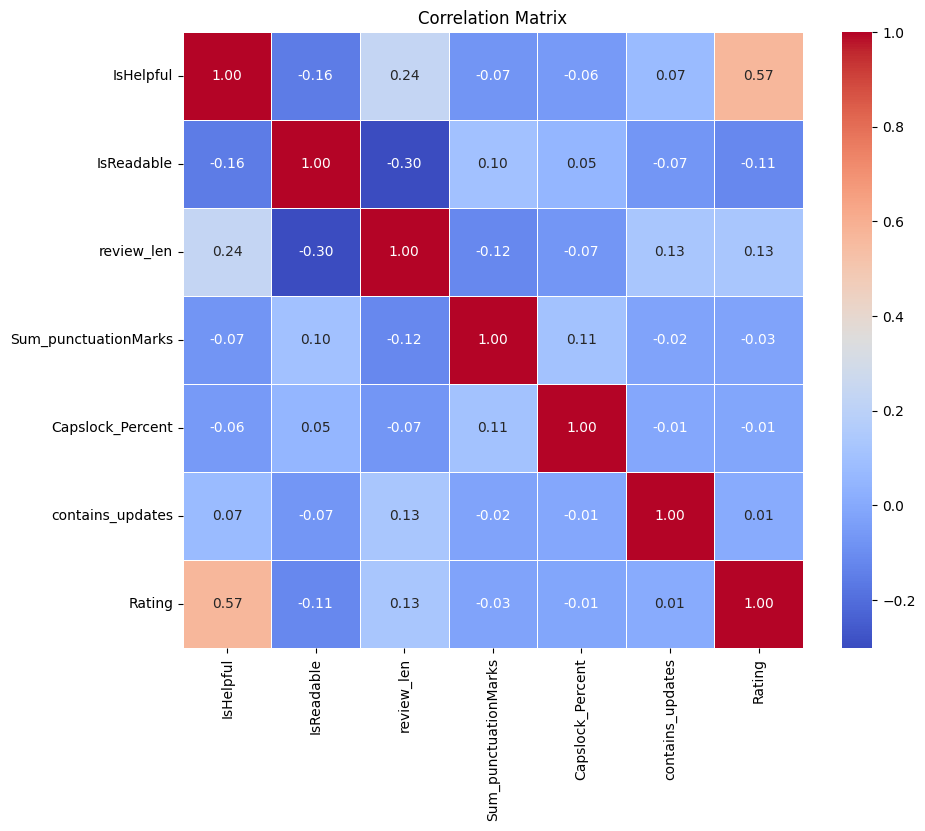

In [22]:
# correlation matrix for factors
variables = ['IsHelpful', 'IsReadable', 'review_len', 'Sum_punctuationMarks', 'Capslock_Percent', 'contains_updates', 'Rating']

# Select the relevant columns from your DataFrame
selected_data = df[variables]

# Create a correlation matrix
correlation_matrix = selected_data.corr()

# Plot the correlation matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

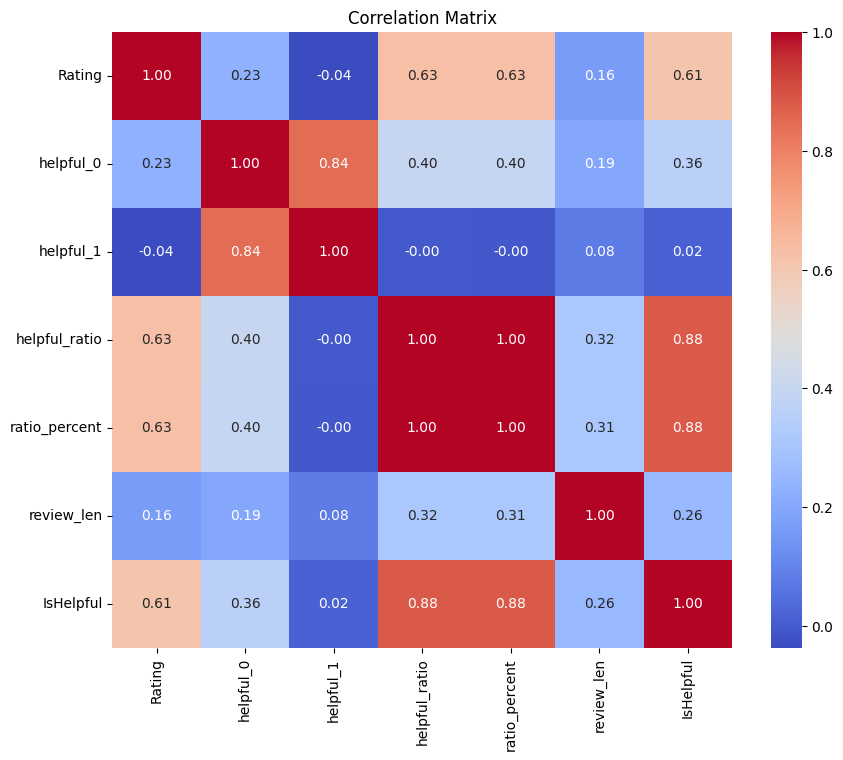

In [11]:
# Select only numeric columns
numeric_columns = df_modified.select_dtypes(include=['number']).columns
correlation_matrix = df_modified[numeric_columns].corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

## Originaler Datensatz

In [61]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm 
import textstat


tqdm.pandas()

In [12]:
df = pd.read_csv('../Datasets/Books_rating.csv')

In [15]:
df[['helpful_0', 'helpful_1']] = df['review/helpfulness'].str.split('/', expand=True)

# Konvertieren der 'helpfulness'-Spalte in numerische Werte (falls notwendig)
#df['review/helpfulness'] = pd.to_numeric(df['review/helpfulness'], errors='coerce')

df.head()

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text,helpful_0,helpful_1
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...,7,7
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...,10,10
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t...",10,11
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D...",7,7
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...,3,3


In [18]:
df['helpful_0'] = df['helpful_0'].progress_apply(pd.to_numeric)
df['helpful_1'] = df['helpful_1'].progress_apply(pd.to_numeric)

  0%|          | 0/3000000 [00:00<?, ?it/s]

  0%|          | 0/3000000 [00:00<?, ?it/s]

In [19]:
df['helpful_0'] = df['helpful_0'].astype(int)
df['helpful_1'] = df['helpful_1'].astype(int)

In [32]:
df.drop(['Id', 'Title', 'Price', 'User_id', 'profileName', 'review/time', 'review/summary'], axis='columns', inplace=True)


df = df.rename(columns={"helpful_0":"votes_helpful", "helpful_1":"votes_total", "ratio_percent":"helpful_percent"})
df = df.rename(columns={"review/text":"Review","review/score": "Rating"})
df.head()

KeyError: "['Id', 'Title', 'Price', 'User_id', 'profileName', 'review/time', 'review/summary'] not found in axis"

In [30]:
# Check for missing values in the "Review" column
missing_values = df['Review'].isnull()

# Replace missing values with an empty string or any other appropriate value
df['Review'].fillna('', inplace=True)

# Apply the len function to calculate the length of each review
df['review_len'] = df['Review'].apply(len)

In [34]:
df = df.rename(columns={"helpful_0":"votes_helpful", "helpful_1":"votes_total", "ratio_percent":"helpful_percent"})
df.head()

,review/helpfulness,Rating,Review,votes_helpful,votes_total,review_len
0,7/7,4.0,This is only for Julie Strain fans. It's a col...,7,7,457
1,10/10,5.0,I don't care much for Dr. Seuss but after read...,10,10,1423
2,10/11,5.0,"If people become the books they read and if ""t...",10,11,1752
3,7/7,4.0,"Theodore Seuss Geisel (1904-1991), aka &quot;D...",7,7,3662
4,3/3,4.0,Philip Nel - Dr. Seuss: American IconThis is b...,3,3,1542


### ARI

In [39]:
def calculate_ari(text):
    ari = textstat.automated_readability_index(text)
    return ari

In [40]:
df['ARI'] = df['Review'].apply(calculate_ari)

In [42]:
# Zähle die Anzahl der Reviews mit einem ARI-Wert von weniger als 8
low_ari_reviews = df[df['ARI'] < 8]
num_low_ari_reviews = len(low_ari_reviews)

print(f"Anzahl der Reviews mit ARI < 8: {num_low_ari_reviews}")

Anzahl der Reviews mit ARI < 8: 1292505


In [43]:
low_ari_reviews = df[df['ARI'] > 8]
num_low_ari_reviews = len(low_ari_reviews)

print(f"Anzahl der Reviews mit ARI > 8: {num_low_ari_reviews}")

Anzahl der Reviews mit ARI > 8: 1677080


In [45]:
def convert_ari(df):
    if df['ARI'] <= 8.0:
        ari = 1 # for readable
    else:
        ari = 0 # for not readable
    return ari

In [46]:
df['IsReadable'] = df.apply(convert_ari, axis=1)
df.head()

,review/helpfulness,Rating,Review,votes_helpful,votes_total,review_len,ARI,IsReadable
0,7/7,4.0,This is only for Julie Strain fans. It's a col...,7,7,457,8.0,1
1,10/10,5.0,I don't care much for Dr. Seuss but after read...,10,10,1423,13.1,0
2,10/11,5.0,"If people become the books they read and if ""t...",10,11,1752,10.4,0
3,7/7,4.0,"Theodore Seuss Geisel (1904-1991), aka &quot;D...",7,7,3662,12.7,0
4,3/3,4.0,Philip Nel - Dr. Seuss: American IconThis is b...,3,3,1542,8.1,0


### helpfulness

In [47]:
def convert_label(df) : 
    if df['ratio_percent'] <= 70 : 
        rate = 0 # for Negative 
    else : 
        rate = 1 # for Positive
        
    return rate

In [54]:
num_rows = len(df[df['votes_total'] == 20])
print("Number of rows with helpful_1 > 3: ", num_rows)

Number of rows with helpful_1 > 3:  885732


In [52]:
df['helpful_ratio'] = df['votes_helpful'] / df['votes_total']

In [62]:
# Replace non-finite values with a default value (e.g., 0)
df['helpful_ratio'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)

# Convert the "helpful_ratio" column to a percentage and then to integer
df['ratio_percent'] = (df['helpful_ratio'] * 100).astype(int)

# Display the updated DataFrame
df.head()

,review/helpfulness,Rating,Review,votes_helpful,votes_total,review_len,ARI,IsReadable,helpful_ratio,ratio_percent
0,7/7,4.0,This is only for Julie Strain fans. It's a col...,7,7,457,8.0,1,1.000000,100
1,10/10,5.0,I don't care much for Dr. Seuss but after read...,10,10,1423,13.1,0,1.000000,100
2,10/11,5.0,"If people become the books they read and if ""t...",10,11,1752,10.4,0,0.909091,90
3,7/7,4.0,"Theodore Seuss Geisel (1904-1991), aka &quot;D...",7,7,3662,12.7,0,1.000000,100
4,3/3,4.0,Philip Nel - Dr. Seuss: American IconThis is b...,3,3,1542,8.1,0,1.000000,100


In [63]:
def convert_label(df) : 
    if df['ratio_percent'] <= 70 : 
        rate = 0 # for Negative 
    else : 
        rate = 1 # for Positive
        
    return rate

In [64]:
df['IsHelpful'] = df.apply(convert_label, axis = 1)
df.head()

,review/helpfulness,Rating,Review,votes_helpful,votes_total,review_len,ARI,IsReadable,helpful_ratio,ratio_percent,IsHelpful
0,7/7,4.0,This is only for Julie Strain fans. It's a col...,7,7,457,8.0,1,1.000000,100,1
1,10/10,5.0,I don't care much for Dr. Seuss but after read...,10,10,1423,13.1,0,1.000000,100,1
2,10/11,5.0,"If people become the books they read and if ""t...",10,11,1752,10.4,0,0.909091,90,1
3,7/7,4.0,"Theodore Seuss Geisel (1904-1991), aka &quot;D...",7,7,3662,12.7,0,1.000000,100,1
4,3/3,4.0,Philip Nel - Dr. Seuss: American IconThis is b...,3,3,1542,8.1,0,1.000000,100,1


### Adjectives

In [65]:
# Language
import nltk 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk import pos_tag
from nltk.tokenize import word_tokenize

import re 
from collections import Counter
from string import punctuation

lemma = WordNetLemmatizer()

In [68]:
## achtung dauert so 10 Min
# calculate number of adjectives per review
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('stopwords')

#def count_adjectives(text):
    #words = word_tokenize(text)
    #words = [word.lower() for word in words if word.isalpha() and word.lower() not in stopwords.words('english')]
    #pos_tags = pos_tag(words)
    #adjectives = [word for word, tag in pos_tags if tag.startswith('JJ')]
    #return len(adjectives)

#df['Adjective_Count'] = df['Review'].progress_apply(count_adjectives)
#df['Adjective_Ratio'] = df['Adjective_Count'] / df['review_len']

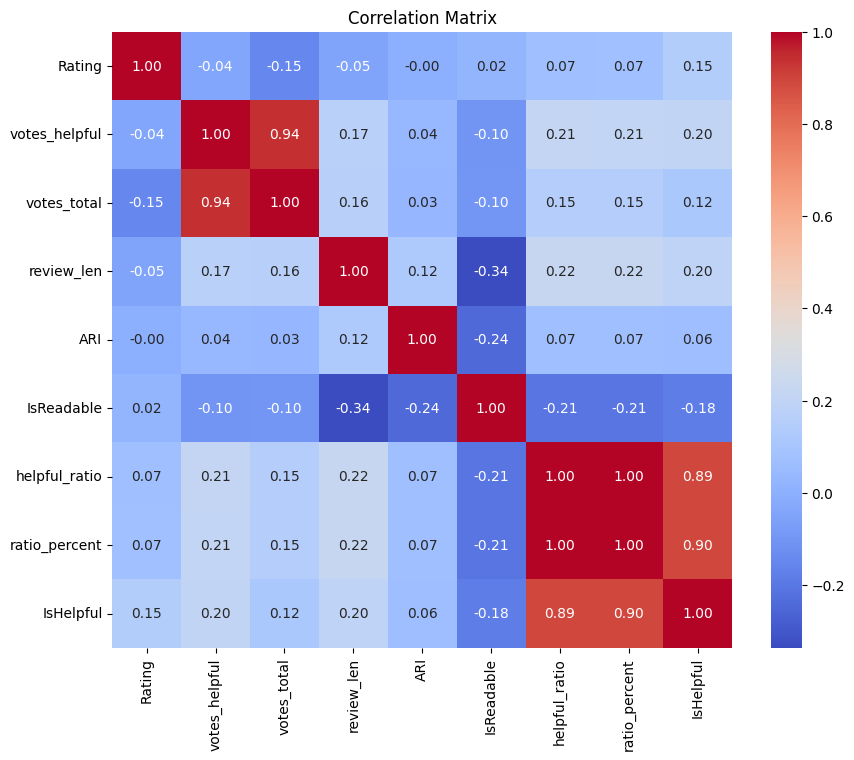

In [69]:
# Select only numeric columns
numeric_columns = df.select_dtypes(include=['number']).columns
correlation_matrix = df[numeric_columns].corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [71]:
df.drop(["votes_helpful", "votes_total", "helpful_ratio", "ratio_percent"], axis="columns", inplace=True)

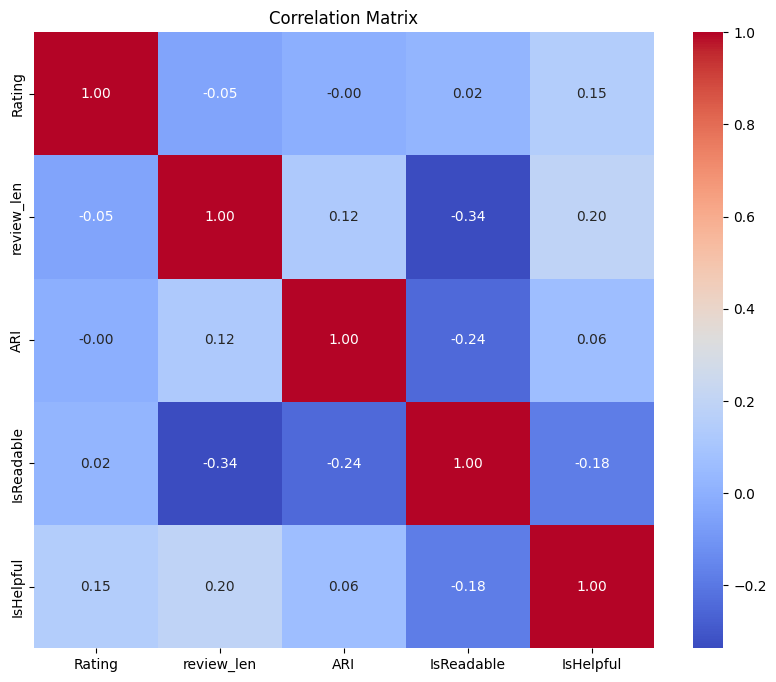

In [72]:
# Select only numeric columns
numeric_columns = df.select_dtypes(include=['number']).columns
correlation_matrix = df[numeric_columns].corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [74]:
df.head(50)

,review/helpfulness,Rating,Review,review_len,ARI,IsReadable,IsHelpful
0,7/7,4.0,This is only for Julie Strain fans. It's a col...,457,8.0,1,1
1,10/10,5.0,I don't care much for Dr. Seuss but after read...,1423,13.1,0,1
2,10/11,5.0,"If people become the books they read and if ""t...",1752,10.4,0,1
3,7/7,4.0,"Theodore Seuss Geisel (1904-1991), aka &quot;D...",3662,12.7,0,1
4,3/3,4.0,Philip Nel - Dr. Seuss: American IconThis is b...,1542,8.1,0,1
5,2/2,4.0,"""Dr. Seuss: American Icon"" by Philip Nel is a ...",1975,15.7,0,1
6,3/4,5.0,Theodor Seuss Giesel was best known as 'Dr. Se...,533,9.4,0,1
7,0/0,5.0,When I recieved this book as a gift for Christ...,1219,8.7,0,0
8,0/0,5.0,Trams (or any public transport) are not usuall...,362,8.9,0,0
9,3/5,4.0,"As far as I am aware, this is the first book-l...",1399,10.4,0,0
